# Image generation

## Style transfer

### Setup

In [8]:
from time import time

import numpy as np
from keras.models import Model
import keras.backend as K
from keras import metrics
from scipy.optimize import fmin_l_bfgs_b

from PIL import Image
from scipy.misc import imsave
from IPython.display import HTML
from matplotlib import animation
import matplotlib.pyplot as plt
%matplotlib inline

from vgg16_avg import VGG16_Avg

def limit_mem():
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))
limit_mem()

def plots(ims, figsize=(12,6), rows=1, cols=None, interp=None, titles=None, cmap=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        if titles is not None:
            sp.set_title(titles[i], fontsize=18)
        plt.imshow(ims[i], interpolation=interp, cmap=cmap)
        plt.axis('off') # New
        plt.subplots_adjust(hspace = 0.500) # New
    return

class Evaluator(object):
    def __init__(self, function, shape):
        self.function = function
        self.shape = shape
    
    def loss(self, x):
        loss_, self.grad_values = self.function([x.reshape(self.shape)])
        return loss_.astype(np.float64)
    
    def grads(self, x):
        return self.grad_values.flatten().astype(np.float64)
    
def solve_image(evaluator, nb_iterations, x, shape):
    imsave("{}results/result_at_iteration_{}_0.png".format(path, start), x[0])
    for i in range(nb_iterations+1):
        x, min_val, info = fmin_l_bfgs_b(func=evaluator.loss,
                                         x0=x.flatten(),
                                         fprime=evaluator.grads,
                                         maxfun=20)
        x = np.clip(x, -127, 127)
        print('Current loss value: ', min_val)
        imsave("{}results/result_at_iteration_{}_{}.png".format(path, start, i+1), deproc(x.copy(), shape)[0])
    return x

def gram_matrix(layer_activation):
    features = K.batch_flatten(K.permute_dimensions(layer_activation, (2, 0, 1)))
    return K.dot(features, K.transpose(features)) / layer_activation.get_shape().num_elements()

def layer_loss(layer_activation, target_layer_activation):
    return metrics.mse(gram_matrix(layer_activation), gram_matrix(target_layer_activation))

def plot_arr(arr): plt.imshow(deproc(arr, arr.shape)[0].astype('uint8'))

def animate(i):
    ax.imshow(Image.open("{}results/result_at_iteration_{}_{}.png".format(path, start, i)))
    
imagenet_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - imagenet_mean)[:, :, :, ::-1]
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape) / 100
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + imagenet_mean, 0, 255)

path = "data/imagenet/"

### Generate an image with the content of image 1

#### Load a content image

(1, 332, 500, 3)


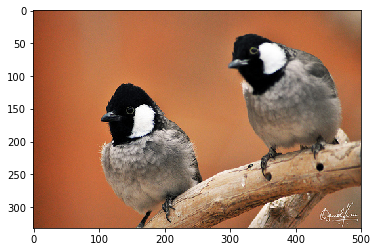

In [11]:
image_1 = Image.open(path+"n01560419/n01560419_13439.JPEG")
plt.imshow(image_1)
content_arr = preproc(np.expand_dims(image_1, 0))
shape = content_arr.shape
print(shape)

#### Create a random image

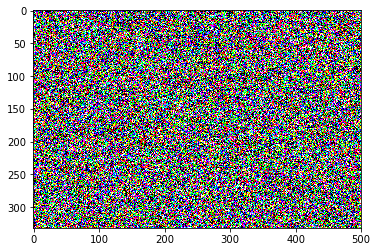

In [12]:
x = rand_img(shape)
plt.imshow(x[0]);

#### Create a model

Current loss value:  64.6945877075
Current loss value:  23.2708797455
Current loss value:  14.0286273956
Current loss value:  10.0555868149
Current loss value:  8.04069232941
Current loss value:  6.74049377441
Current loss value:  5.87743663788
Current loss value:  5.24162054062
Current loss value:  4.71759033203
Current loss value:  4.33254146576
Current loss value:  3.97623586655


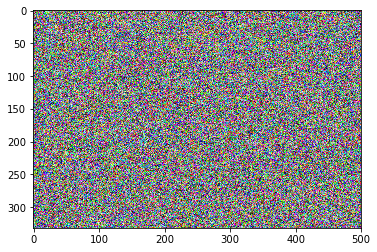

In [13]:
model = VGG16_Avg(include_top=False)
layer_activation = model.get_layer('block5_conv1').output
layer_model = Model(model.input, layer_activation) # similar to popping off all layers after our layer of interest?
target_layer_activation = K.variable(layer_model.predict(content_arr))

loss = metrics.mse(layer_activation, target_layer_activation)
grads = K.gradients(loss, model.input)

function_input = [model.input]
function_output = [loss]+grads # this is a two-element list
function = K.function(function_input, function_output)
evaluator = Evaluator(function, shape)

nb_iterations = 10
start = int(time())
x_final = solve_image(evaluator, nb_iterations, x, shape)

fig, ax = plt.subplots()
anim = animation.FuncAnimation(fig, animate, frames=nb_iterations+1, interval=200)
HTML(anim.to_html5_video())

### Generate an image with the style of image 2

#### Load a style image

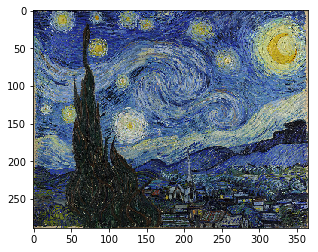

In [14]:
image_2 = Image.open('data/starry_night.jpg')
image_2 = image_2.resize(np.divide(image_2.size, 3.5).astype('int32'))
style_arr = preproc(np.expand_dims(image_2 ,0)[:,:,:,:3])
shape = style_arr.shape
plt.imshow(image_2);

#### Create a random image

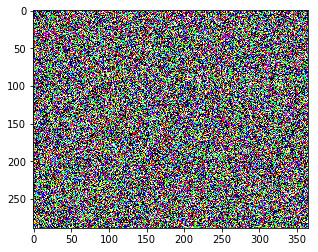

In [15]:
x = rand_img(shape)
plt.imshow(x[0]);

#### Create a model

Current loss value:  17053.6972656
Current loss value:  546.844604492
Current loss value:  181.125061035
Current loss value:  106.839294434
Current loss value:  80.0961303711
Current loss value:  62.4557876587
Current loss value:  48.7221069336
Current loss value:  37.9952430725
Current loss value:  30.7982940674
Current loss value:  23.5022010803
Current loss value:  17.3325424194


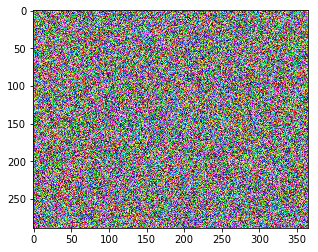

In [19]:
model = VGG16_Avg(include_top=False, input_shape=shape[1:])
layer_activations = [model.get_layer('block{}_conv1'.format(i)).output for i in range(1, 4)]
layers_model = Model(model.input, layer_activations)
target_layer_activations = [K.variable(layer_activation) for layer_activation in layers_model.predict(style_arr)]

layer_losses = [layer_loss(la[0], tla[0]) for la, tla in zip(layer_activations, target_layer_activations)]
loss = sum(layer_losses)
grads = K.gradients(loss, model.input)
function = K.function([model.input], [loss]+grads) # [loss]+grads is a two-element list
evaluator = Evaluator(function, shape)

nb_iterations = 10
start = int(time())
x_final = solve_image(evaluator, nb_iterations, x, shape)

fig, ax = plt.subplots()
anim = animation.FuncAnimation(fig, animate, frames=nb_iterations+1, interval=200)
HTML(anim.to_html5_video())

### Generate an image with the content of image 1 and the style of image 2

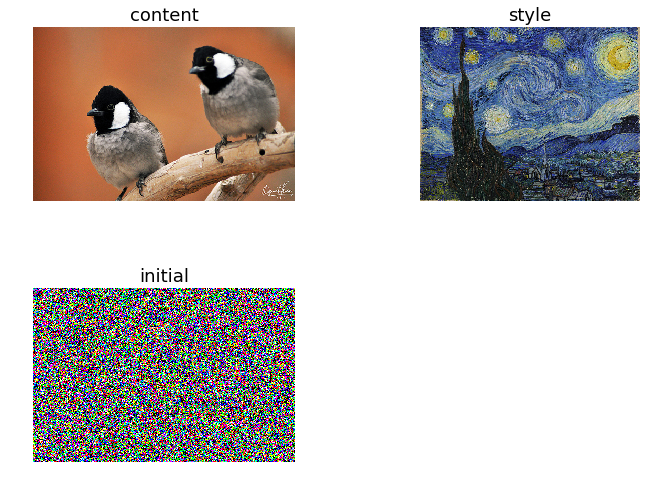

In [20]:
# content image
image_1 = Image.open(path+"n01560419/n01560419_13439.JPEG")
content_arr = preproc(np.expand_dims(image_1, 0))
shape = content_arr.shape

# style image
image_2 = Image.open('data/starry_night.jpg')
image_2 = image_2.resize(np.divide(image_2.size, 2).astype('int32'))
style_arr = preproc(np.expand_dims(image_2, 0))

# initial image
initial = rand_img(shape)

# plot images
images = [image_1, image_2, initial[0]]
plots(images, rows=2, cols=2, titles=["content", "style", "initial"], figsize=(12,8))

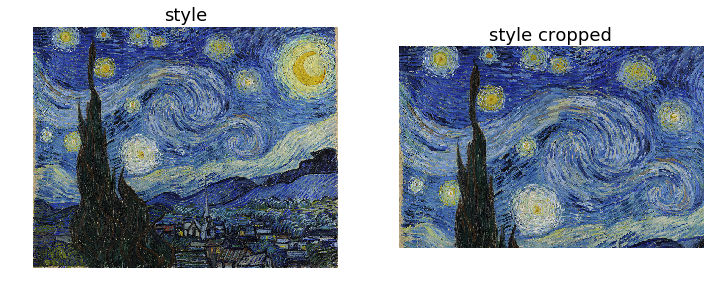

In [21]:
# crop style image to fit content image
w, h = image_1.size
style_arr = style_arr[:, :h, :w]

style_cropped = deproc(style_arr, style_arr.shape)[0].astype('uint8')
plots([image_2, style_cropped], rows=1, cols=2, titles=["style", "style cropped"], figsize=(12,8))

In [ ]:
# original model
model = VGG16_Avg(include_top=False, input_shape=shape[1:])

# content model
layer_activation = model.get_layer('block4_conv2').output
content_model = Model(model.input, layer_activation)
target_layer_activation = K.variable(content_model.predict(content_arr))
content_loss = metrics.mse(layer_activation, target_layer_activation)

# style model
layer_activations = [model.get_layer('block{}_conv1'.format(i)).output for i in range(1, 4)]
style_model = Model(model.input, layer_activations)
target_layer_activations = [K.variable(layer_activation) for layer_activation in style_model.predict(style_arr)]
layer_losses = [layer_loss(la[0], tla[0]) for la, tla in zip(layer_activations, target_layer_activations)]
style_loss = sum(layer_losses)

# merge
loss = content_loss / 10 + style_loss
grads = K.gradients(loss, model.input)
function = K.function([model.input], [loss]+grads) # [loss]+grads is a two-element list
evaluator = Evaluator(function, shape)

nb_iterations = 10
start = int(time())
x_final = solve_image(evaluator, nb_iterations, initial, shape)

Current loss value:  21155.6015625
Current loss value:  772.258605957
Current loss value:  403.983154297
Current loss value:  323.496917725
Current loss value:  281.10546875


In [ ]:
result = Image.open(path+'results/result_at_iteration_%d_11.png' % start)
style_cropped = deproc(style_arr, style_arr.shape)[0].astype('uint8')
images = [image_1, style_cropped, initial[0], result]
plots(images, rows=2, cols=2, titles=["content", "style", "initial", "merged"], figsize=(12,8))

In [ ]:
fig, ax = plt.subplots()
anim = animation.FuncAnimation(fig, animate, frames=nb_iterations+1, interval=200)
HTML(anim.to_html5_video())